# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

import cProfile
import re
import time

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Solve, Statistics, Classes

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
# comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

In [3]:
# pip install networkx
# pip install nbconvert

### Roie Larger Network

In [4]:
NGrid = 10  # lattice dimansion is Ngrid X Ngrid
# input_output_pairs = np.array([[(NGrid+2)*5-1, (NGrid*(NGrid-2)+2)*5-1], 
#                               [(NGrid*(NGrid-1)-1)*5-1, (2*NGrid-1)*5-1]])

# NGrid = 3  # lattice dimansion is Ngrid X Ngrid
# task_type = 'Allostery_one_pair'
# task_type = 'Allostery'  # 2 pairs of input and outputs
# task_type = 'XOR'  # 2 inputs and 2 outputs. difference between output nodes encodes the XOR result of the 2 inputs
# task_type = 'Channeling_diag'  # first do from input to output, then from output to 2 perpindicular nodes. 
#                                # test from input to output
task_type = 'Channeling_straight' # first do from input to output, then from output to 2 perpindicular nodes. 
                                  # test from input to output
# row = int(np.floor(np.sqrt(NGrid))-1)  # row (and column) of input and output nodes in the NGrid X NGrid cell array
row = 1
if task_type == 'Allostery' or task_type == 'XOR':
    input_output_pairs = np.array([[(row*NGrid+(row+1))*5-1, (NGrid*(NGrid-(row+1))+(row+1))*5-1], 
                                  [(NGrid*(NGrid-row)-row)*5-1, ((row+1)*NGrid-row)*5-1]])
    if task_type == 'XOR':
        fixed_node_pairs = np.array([[(NGrid*int(np.floor(NGrid/2))+2)*5-1],
                                     [(NGrid*int(np.floor(NGrid/2))+(NGrid-row))*5-1]])
    else:
        fixed_node_pairs = np.array([])
elif task_type == 'Channeling_diag' or task_type=='Channeling_straight':
    n_every_row = 3
    from_node = 0
    to_node = 2
    all_nodes_bot = np.arange((row*NGrid+(row+1))*5-1,((row+1)*NGrid-row)*5, 5)
    all_nodes_top = np.arange((NGrid*(NGrid-(row+1))+(row+1))*5-1, (NGrid*(NGrid-row)-row)*5, 5)
    idx = np.round(np.linspace(0, len(all_nodes_bot) - 1, n_every_row)).astype(int)
    input_output_pairs = np.array([all_nodes_bot[idx], all_nodes_top[idx]])
    print(input_output_pairs)
    if task_type == 'Channeling_diag':
        input_output_pairs = array([[input_output_pairs[0, from_node], input_output_pairs[1, to_node]], 
                                   [input_output_pairs[0, to_node], input_output_pairs[1, from_node]]])
    elif task_type == 'Channeling_straight':
        input_output_pairs = array([[input_output_pairs[0, from_node], input_output_pairs[1, from_node]], 
                                   [input_output_pairs[0, to_node], input_output_pairs[1, to_node]]])
            
    fixed_node_pairs = np.array([])
else:
    input_output_pairs = np.array([[(row*NGrid+int(np.ceil(NGrid/2)))*5-1, 
                                    (NGrid*(NGrid-(row+1))+int(np.ceil(NGrid/2)))*5-1], 
                                  [(row*NGrid+int(np.ceil(NGrid/2)))*5-1, 
                                    (NGrid*(NGrid-(row+1))+int(np.ceil(NGrid/2)))*5-1]])
    fixed_node_pairs = np.array([])

print('input output node pairs are:\n' + str(input_output_pairs) +'\n \n' + 'fixed nodes are:\n' 
      + str(fixed_node_pairs) + '\n')

Periodic = False  # flag for lattice periodicity
net_typ = 'Cells'
u_thresh = 1  # threshold to move marbles

if task_type == 'Allostery_one_pair':
    K_scheme = 'propto_current_squared'
    flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
else:
    K_scheme = 'marbles_pressure'
    flow_scheme = 'unidir'  # apply pressure drop only in the regular directions - constrained node = positive, ground = 0
                            # there are 2 input and output pairs, exchange between them
    # flow_scheme = 'taktak'  # apply pressure drop unidir once, meaning 1st input and output pair and then 2nd pair.
                              # then switch ground and constrained nodes to apply oposite dir.
# K_type = 'bidir'  # conductivity is the same regardless of flow directions
K_type = 'flow_dep'  # conductivity depends on flow direction - if into cell then maximal, 
                     # if out and there is a marble then lower
beta = 10**(-2)
# beta = 0
# print('beta is:' + str(beta))

K_max = 1
# K_min = np.array([0.5])
# K_min = np.array([0.03, 0.04])
K_min = np.array([1/(4*(NGrid-2*row)-1)])
# K_min = np.logspace(-4, 0, num=20, base=10)
# print('K_min is:')
# for i in K_min:
#     print(i)

# input_p = arange(0.1, 7, 0.16)
# input_p = np.logspace(1.25, 4, num=20, base=10)
input_p = np.array([4e4])
print('pressure is:')
for i in input_p:
    print(i)
    
print('K ratio is:')
for i in K_min:
    print(i)

iterations = 16

## Variabs

Variabs = Classes.User_variables(NGrid, Periodic, net_typ, u_thresh, input_p, flow_scheme, task_type, K_scheme, K_type, 
                                 iterations, input_output_pairs, fixed_node_pairs, K_max=K_max, K_min=K_min, beta=beta)

[[ 59  79  94]
 [409 429 444]]
input output node pairs are:
[[ 59 409]
 [ 94 444]]
 
fixed nodes are:
[]

pressure is:
40000.0
K ratio is:
0.03225806451612903


In [5]:
print('K ratio is:')
for i in K_min:
    print(i)

K ratio is:
0.03225806451612903


In [6]:
## Build Incidence Matrices and vectors of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)

In [7]:
## Initiate Network state and K matrix

State = Classes.Net_state()
State.initiateK(Variabs, Strctr)

In [8]:
## build network and plot structure

NET = Classes.Networkx_net()
NET.buildNetwork(Strctr)
NET.build_pos_lattice(Variabs)
pos_lattice = NETfuncs.plotNetStructure(NET.NET, plot='no')

NET is ready
NET is ready


### Main part - loop over both cond and pressure

started main loop
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

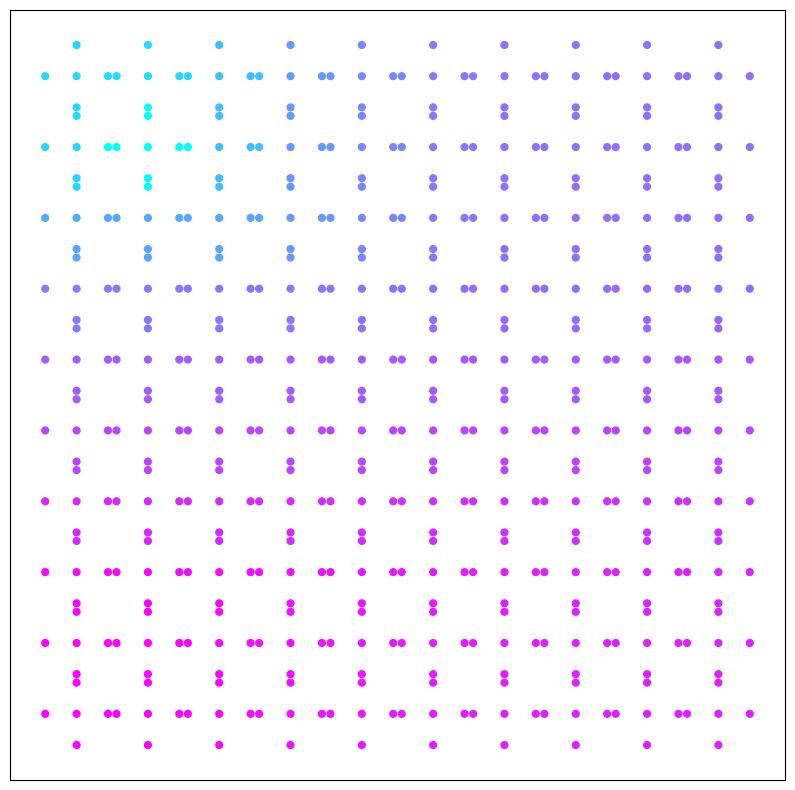

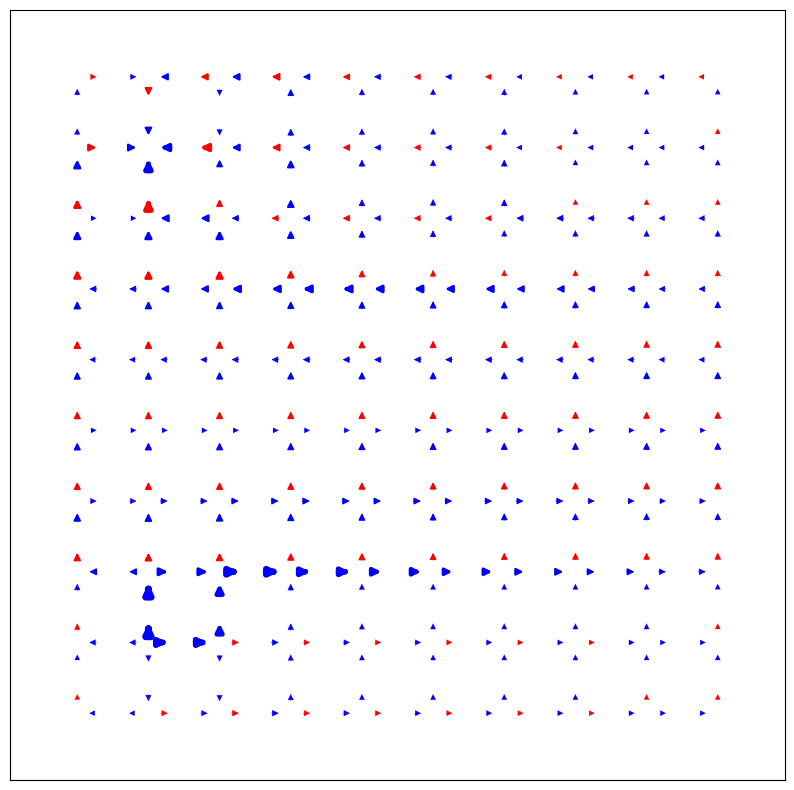

cycle # 0
difference in u 1.000000 
difference in K 72 
difference in u -4.772383 
difference in K 5 
difference in u -0.129724 
difference in K 2 
difference in u -0.090591 
difference in K 2 
difference in u -0.003042 
difference in K 0 
difference in u 0.000000 
difference in K 0 
converged, no further change in K
# iterations 5
condition supplied


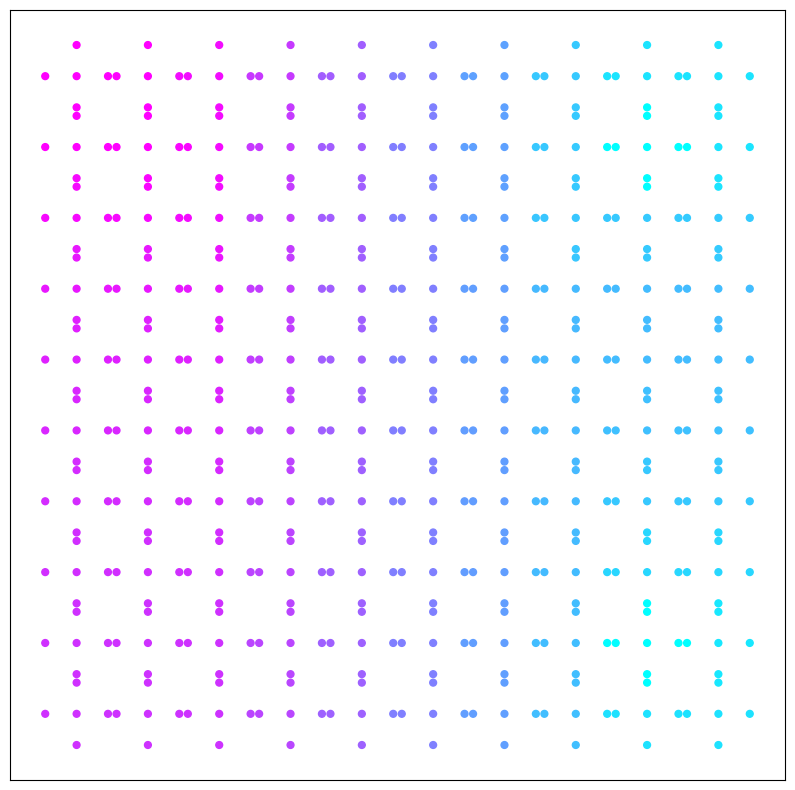

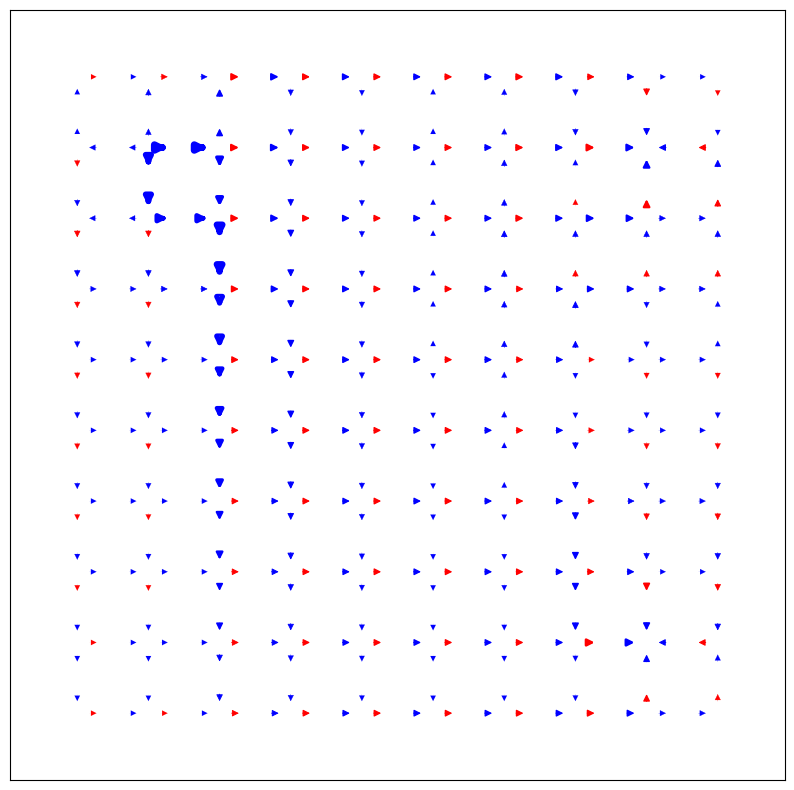

cycle # 1
difference in u 1.000000 
difference in K 42 
difference in u -3.081734 
difference in K 5 
difference in u -0.001591 
difference in K 2 
difference in u -0.004063 
difference in K 2 
difference in u -0.004215 
difference in K 0 
difference in u 0.000000 
difference in K 0 
converged, no further change in K
# iterations 5
condition supplied


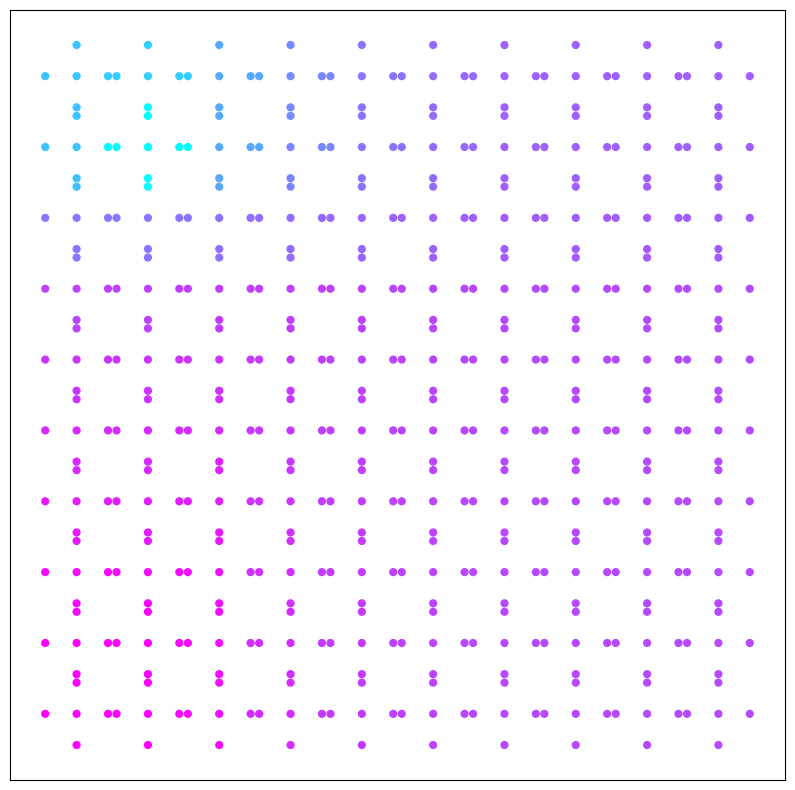

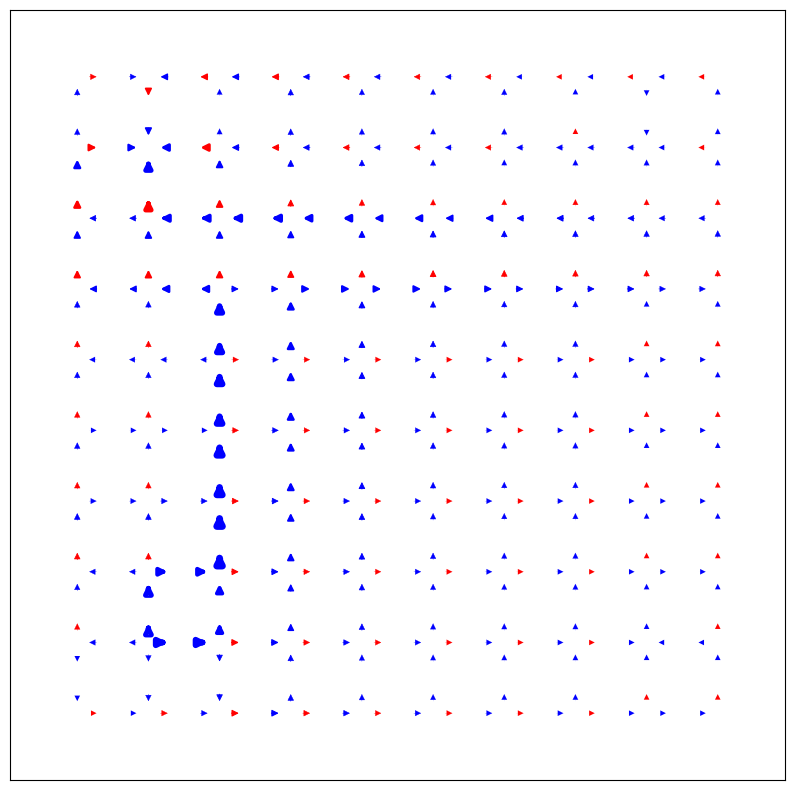

[1.         1.         0.03225806 1.         1.         1.
 0.03225806 1.         1.         1.         0.03225806 1.
 1.         1.         0.03225806 1.         1.         1.
 0.03225806 1.         1.         1.         0.03225806 1.
 1.         1.         0.03225806 1.         1.         1.
 0.03225806 1.         1.         1.         1.         0.03225806
 1.         1.         1.         0.03225806 1.         1.
 1.         0.03225806 1.         1.         1.         1.
 1.         1.         0.03225806 1.         1.         1.
 0.03225806 1.         1.         1.         0.03225806 1.
 1.         1.         0.03225806 1.         1.         1.
 0.03225806 1.         1.         1.         0.03225806 1.
 1.         1.         1.         1.         1.         1.
 1.         0.03225806 1.         1.         1.         0.03225806
 1.         1.         1.         0.03225806 1.         1.
 0.03225806 1.         1.         1.         0.03225806 1.
 1.         1.         0.03225806 1.    

In [9]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
power_dissip_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
convergence_time_vec = np.zeros([len(K_min), len(input_p) ])
shear_vec = np.zeros([len(K_min), len(input_p)])  # 
u_allostery_arr = np.zeros([2, 2, len(K_min), len(input_p)])  # 

# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(Variabs)

origin = np.array([[0, 0],[0, 0]]) # origin point

print('started main loop')
count_index = 0

for i, K_min_i in enumerate(K_min):
    
    # K min into Variabs Class 
    Variabs.assign_K_min(K_min_i)
    
    for j, p in enumerate(input_p):
        
        start = time.time()

        # input pressure into Variabs Class
        Variabs.assign_input_p(p)

        # Set up constraints for whole loop
        Strctr.Setup_constraints(Variabs)

        # Initiate K matrix again, not mandatory, better not doing it actually
        State.initiateK(Variabs, Strctr, noise='yes')
        print(State.K)

        # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
        #        change constraints and repeat
        State.flow_iterate(Variabs, Strctr, NET, sim_type='w marbles', plot='yes', savefig='yes')
        
        print(State.K)

        MSE_arr[:, i, j] = State.MSE
        Hamming_arr[:, i, j] = State.Hamming
        # print(State.power_dissip)
        power_dissip_arr[:, i, j] = State.power_dissip
        convergence_time_vec[i, j] = State.convergence_time
      
        datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
        df_p = pd.DataFrame(np.array(State.p))
        df_p.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_p=" + str(p) + "_K_ratio=" + str(K_min_i) + "_p_field.csv")
        df_u = pd.DataFrame(np.array(State.u_all[:,-1]))
        df_u.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_p=" + str(p) + "_K_ratio=" + str(K_min_i) + "_u_field.csv")
        df_K = pd.DataFrame(np.array(State.K))
        df_K.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_p=" + str(p) + "_K_ratio=" + str(K_min_i) + "_K.csv")

        end = time.time()
        dt = end-start
        print('total time for simulation %f' %dt)
        
convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [10]:
print(np.size(State.u_all[:,0]))
print(State.u_all[0:NGrid**2*4,0])
Strctr.NN

580
[ 0.00000000e+00  0.00000000e+00  6.26843041e-01 -6.26843041e-01
 -6.26843041e-01  0.00000000e+00 -2.87636459e+01  2.93904889e+01
  2.87636459e+01  0.00000000e+00 -5.13278676e+01  2.25642217e+01
  5.13278676e+01  0.00000000e+00 -3.01022225e+01 -2.12256451e+01
  3.01022225e+01  0.00000000e+00 -2.20317302e+01 -8.07049232e+00
  2.20317302e+01  0.00000000e+00 -1.65568310e+01 -5.47489920e+00
  1.65568310e+01  0.00000000e+00 -1.17412564e+01 -4.81557461e+00
  1.17412564e+01  0.00000000e+00 -5.49977291e+00 -6.24148350e+00
  5.49977291e+00  0.00000000e+00 -2.71836278e+00 -2.78141013e+00
  2.71836278e+00  0.00000000e+00  0.00000000e+00 -2.71836278e+00
  0.00000000e+00  6.26843041e-01  4.00468206e+01 -4.06736637e+01
 -4.00468206e+01 -2.93904889e+01 -4.67044601e+02 -5.72255764e+02
  4.67044601e+02 -2.25642217e+01 -5.40647343e+01 -3.90415645e+02
  5.40647343e+01  2.12256451e+01 -2.92800255e+01 -4.60103539e+01
  2.92800255e+01  8.07049232e+00 -2.18695056e+01 -1.54810122e+01
  2.18695056e+01  5.4

500

In [11]:
Strctr.NN

500

2024_03_21_12_48_34


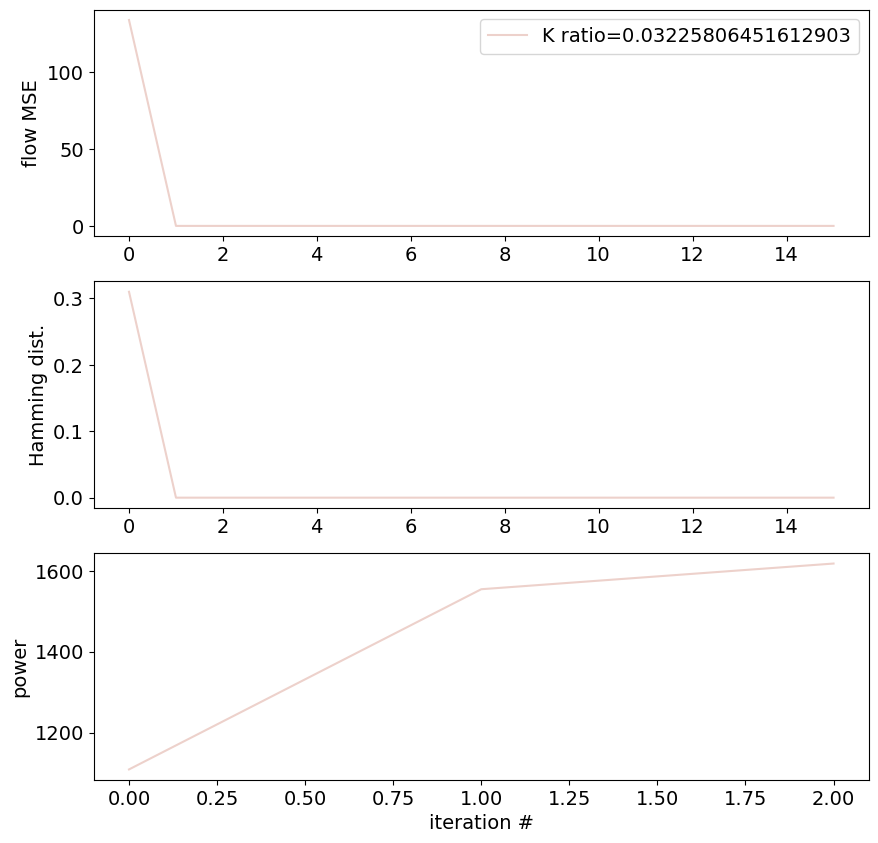

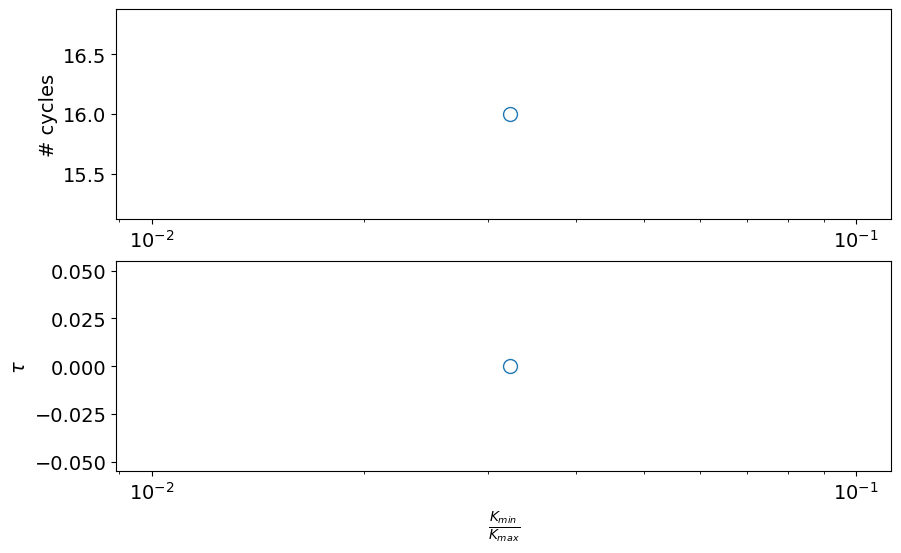

In [12]:
## Figures

# prelims for figures
datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# fig 1 - MSE, Hamming and Power dissip. afo p

fig1, axes1 = plt.subplots(nrows=3)
# axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# cmap = plt.get_cmap('cool')
cmap = sns.cubehelix_palette(as_cmap=True)
colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
legend_every = 10

for i, color in enumerate(colors, start=0):
    if i % legend_every == 0:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
    else:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
    axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
    axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
axes1[0].legend()
# plt.show()
axes1[2].set_xlabel('iteration #')
axes1[0].set_ylabel('flow MSE')
axes1[1].set_ylabel('Hamming dist.')
axes1[2].set_ylabel('power')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# fig 2 - # cycles until convergence and tau p

fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
axes2[0].set_ylabel('# cycles')
# axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\theta$')
axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
axes2[1].set_ylabel('$\\tau$')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

### Main part - loop over many conductivity ratios

In [13]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(K_min)])
# Hamming_arr = np.zeros([Variabs.iterations, len(K_min)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(K_min)])
# convergence_time_vec = np.zeros([len(K_min), ])
# shear_vec = np.zeros([len(K_min), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(K_min)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, K_min_i in enumerate(K_min):
    
#     # save variables into class
#     Variabs.assign_K_min(K_min_i)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='yes')
#     print(State.K)
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     # print(State.power_dissip)
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(K_min)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [14]:
# print(np.mean(State.p))
# np.max(State.p)

In [15]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
# axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

### Main part - loop over many pressures

In [16]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(input_p)])
# Hamming_arr = np.zeros([Variabs.iterations, len(input_p)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(input_p)])
# convergence_time_vec = np.zeros([len(input_p), ])
# # theta_vec = np.zeros([len(input_p), ])
# shear_vec = np.zeros([len(input_p), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(input_p)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, p in enumerate(input_p):
    
#     # save variables into class
#     Variabs.assign_input_p(p)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='no')
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', plot='no', savefig='no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(input_p)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [17]:
# State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes', savefig='yes')

In [18]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='p='+str(input_p[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[i], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(input_p, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(input_p, np.zeros([len(input_p),]))
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

In [19]:
# # Save inportant data as CSV

# # import pandas as pd 

# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # df1 = pd.DataFrame(u_allostery_arr)
# # print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# # df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# df2 = pd.DataFrame(np.array([K_min, convergence_time_vec, shear_vec]))
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")